**EJERCICIO**


In [2]:
pip install opencv-python numpy

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---- ----------------------------------- 4.2/39.0 MB 28.4 MB/s eta 0:00:02
   ---------- ----------------------------- 10.2/39.0 MB 29.2 MB/s eta 0:00:01
   --------------- ------------------------ 14.9/39.0 MB 27.3 MB/s eta 0:00:01
   ---------------------- ----------------- 21.8/39.0 MB 28.6 MB/s eta 0:00:01
   ----------------------- ---------------- 22.8/39.0 MB 24.6 MB/s eta 0:00:01
   ---------------------------- ----------- 27.5/39.0 MB 23.8 MB/s eta 0:00:01
   --------------------------------- ------ 32.2/39.0 MB 23.4 MB/s eta 0:00:01
   ------------------------------------- -- 36.7/39.0 MB 23.1 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 21.9 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


Detectados y guardados 55 recortes en: './recortes'


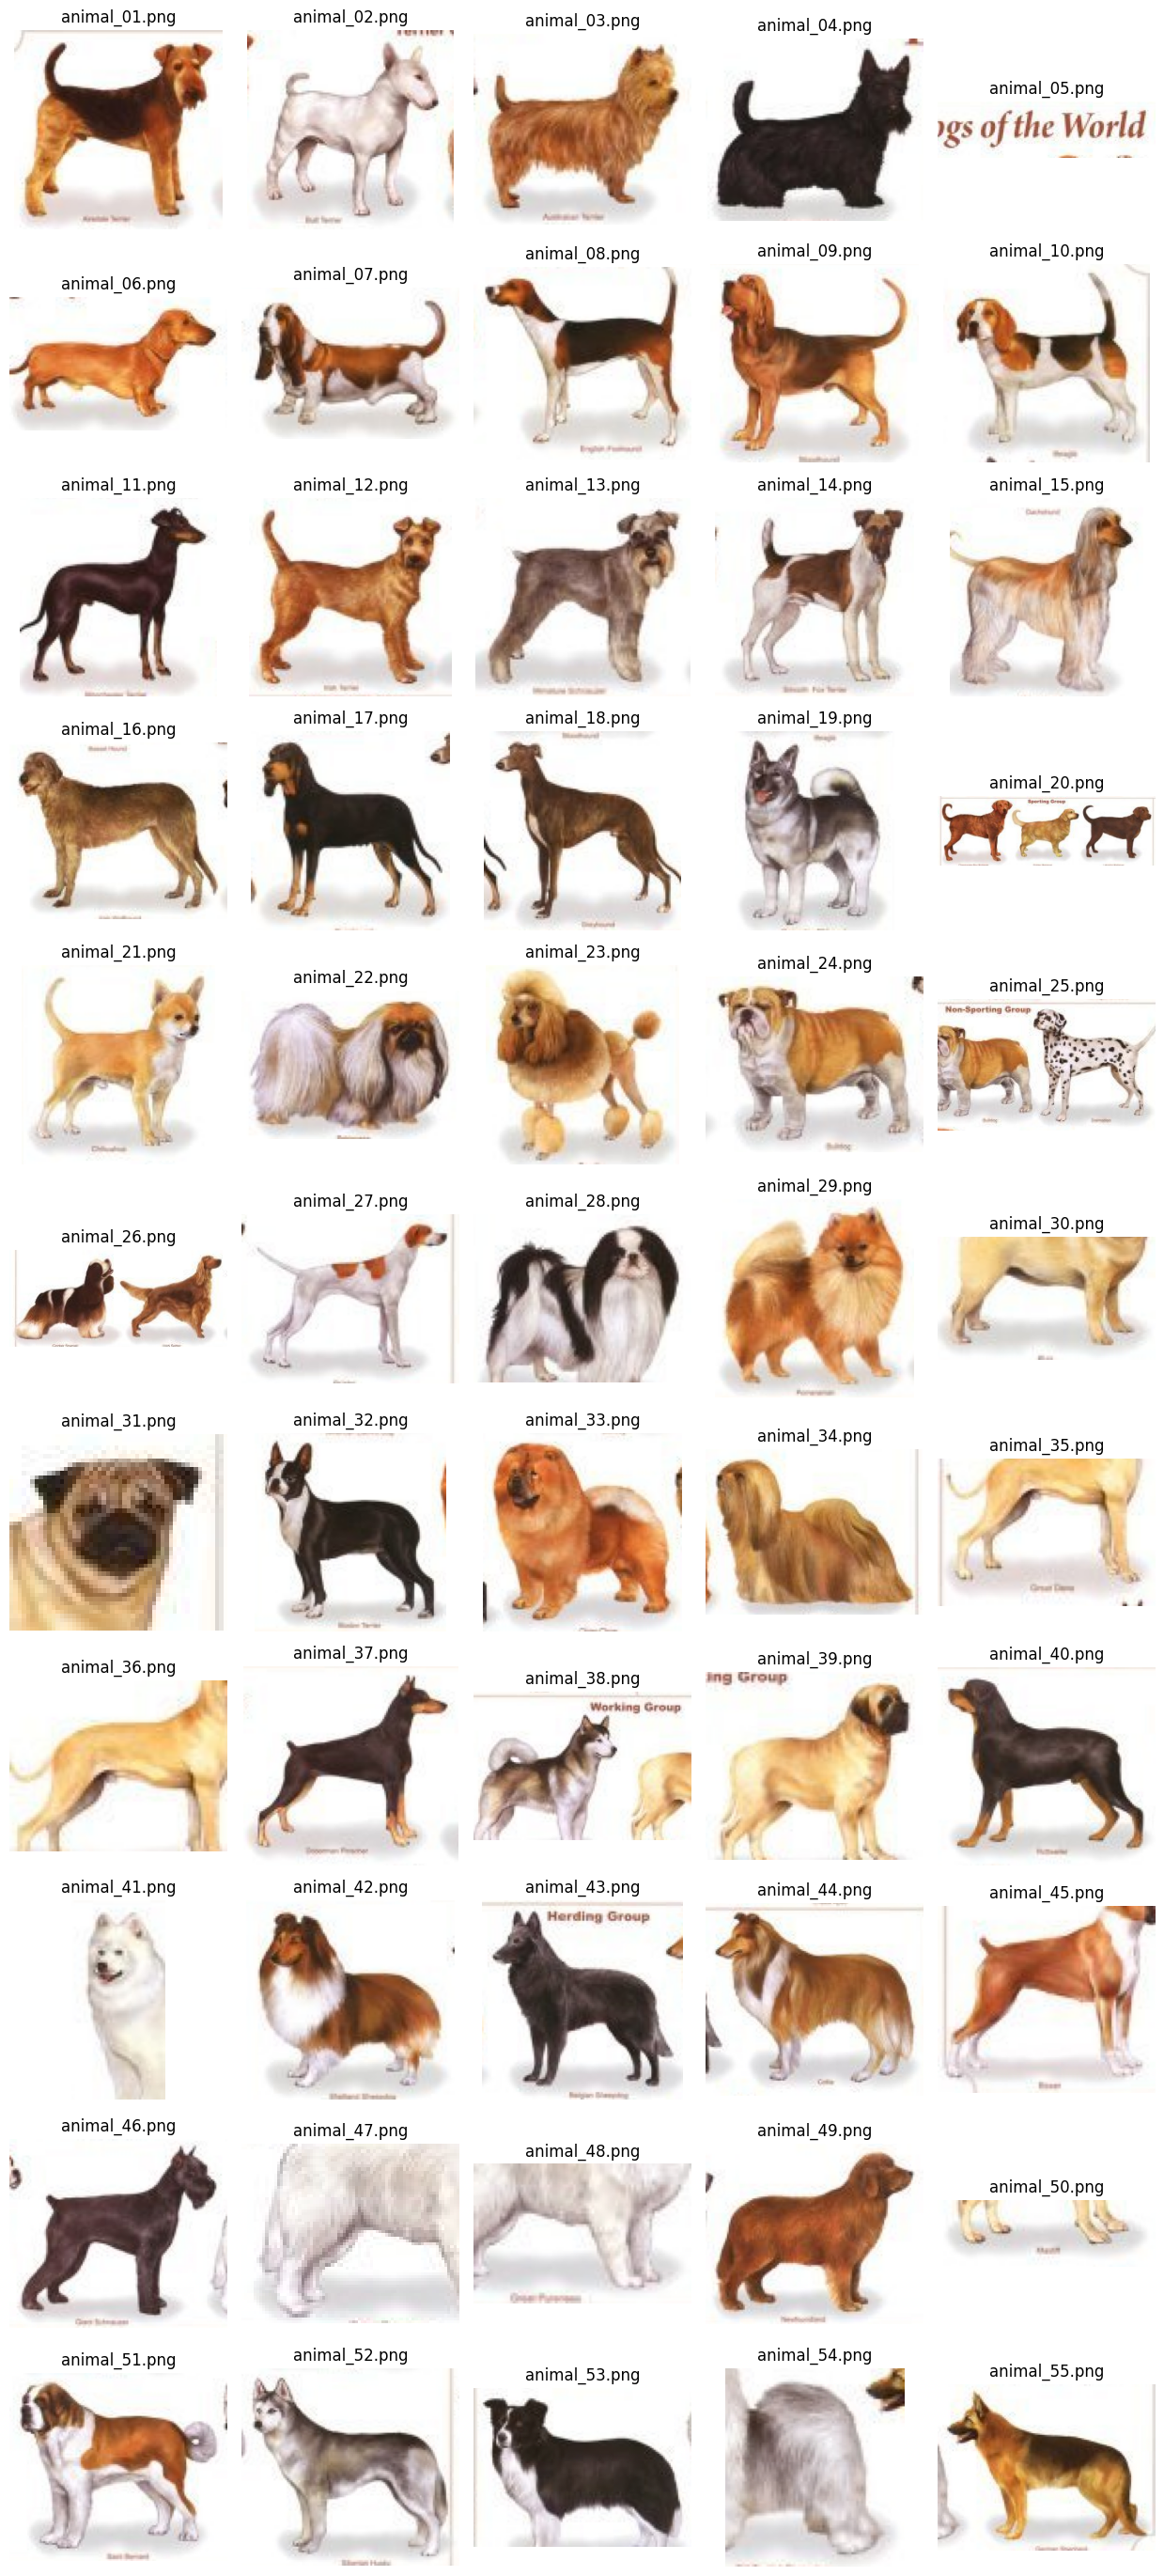

In [ ]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


IMAGE_PATH = "./perros.jpg"   
OUTPUT_DIR = "./recortes"        



MIN_AREA_FRAC = 0.0008  
PAD = 6                 
ADAPTIVE_BLOCK = 51     
ADAPTIVE_C = 8         

def ordenar_bbox(bboxes, img_width, tolerance=0.08):
  
    b = list(bboxes)
    b_sorted = sorted(b, key=lambda r: (r[1], r[0]))
    rows = []
    height_tol = int(tolerance * img_width)
    for rect in b_sorted:
        x,y,w,h = rect
        placed = False
        for row in rows:
            if abs(row[0][1] - y) <= height_tol:
                row.append(rect)
                placed = True
                break
        if not placed:
            rows.append([rect])
    final = []
    for row in rows:
        row_sorted = sorted(row, key=lambda r: r[0])
        final.extend(row_sorted)
    return final

def extraer_y_mostrar(im_path, out_dir,
                      min_area_frac=MIN_AREA_FRAC, pad=PAD,
                      block_size=ADAPTIVE_BLOCK, C=ADAPTIVE_C):
    os.makedirs(out_dir, exist_ok=True)

    img = cv2.imread(im_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer la imagen: {im_path}")

    orig = img.copy()
    h, w = img.shape[:2]


    blur = cv2.GaussianBlur(orig, (5,5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)


    th = cv2.adaptiveThreshold(gray, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,
                               blockSize=block_size, C=C)


    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=2)


    cnts_info = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts_info[0] if len(cnts_info) == 2 else cnts_info[1]


    min_area = min_area_frac * (w * h)
    bboxes = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        x,y,ww,hh = cv2.boundingRect(c)
        if ww < 20 or hh < 20:
            continue
        if ww > 0.95*w and hh > 0.95*h:
            continue
        bboxes.append((x,y,ww,hh))


    if len(bboxes) == 0:
        _, th2 = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
        clean2 = cv2.morphologyEx(th2, cv2.MORPH_OPEN, kernel, iterations=1)
        cnts2_info = cv2.findContours(clean2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts2 = cnts2_info[0] if len(cnts2_info) == 2 else cnts2_info[1]
        for c in cnts2:
            area = cv2.contourArea(c)
            if area < min_area: continue
            x,y,ww,hh = cv2.boundingRect(c)
            bboxes.append((x,y,ww,hh))


    bboxes_ord = ordenar_bbox(bboxes, img_width=w, tolerance=0.08)


    crops_paths = []
    for i, (x,y,ww,hh) in enumerate(bboxes_ord, start=1):
        x0 = max(0, x - pad)
        y0 = max(0, y - pad)
        x1 = min(w, x + ww + pad)
        y1 = min(h, y + hh + pad)
        crop = orig[y0:y1, x0:x1].copy()
        fname = os.path.join(out_dir, f"animal_{i:02d}.png")
        cv2.imwrite(fname, crop)
        crops_paths.append(fname)


    n = len(crops_paths)
    print(f"Detectados y guardados {n} recortes en: '{out_dir}'")
    if n == 0:
       
        fig, ax = plt.subplots(1,2, figsize=(12,5))
        ax[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); ax[0].set_title("Original")
        ax[1].imshow(clean, cmap='gray'); ax[1].set_title("Máscara")
        for a in ax: a.axis('off')
        plt.show()
        return crops_paths


    cols = 5
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
    for i, p in enumerate(crops_paths):
        img_crop = cv2.imread(p)
        img_rgb = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(os.path.basename(p))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    return crops_paths

recortes = extraer_y_mostrar(IMAGE_PATH, OUTPUT_DIR,
                             min_area_frac=MIN_AREA_FRAC,
                             pad=PAD,
                             block_size=ADAPTIVE_BLOCK,
                             C=ADAPTIVE_C)
